In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from matplotlib import pyplot as plt
import numpy as np
import copy
import math

pd.options.display.max_columns = 25
import pickle

In [2]:
f = open('subscribers','rb')
subs = pickle.load(f)

In [3]:
f = open('engagement','rb')
engage = pickle.load(f)

In [4]:
f = open('customer_service_reps','rb')
service = pickle.load(f)

In [5]:
subs

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,country,attribution_technical,...,discount_price,account_creation_date,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,UAE,facebook,...,4.5141,2020-01-24 21:44:16,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,UAE,facebook,...,4.5141,2020-03-01 15:44:35,0.0,False,2020-03-16,False,0.0000,0.3303,ar,False,False,NaN
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,UAE,organic,...,4.5141,2019-12-07 16:37:06,1.0,False,2019-12-22,False,0.0000,0.1101,ar,False,False,NaN
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,UAE,search,...,4.5141,2020-01-27 16:09:32,0.0,False,2020-02-11,False,0.0000,0.0367,ar,False,False,NaN
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,UAE,discovery,...,4.5141,2019-10-05 12:57:07,9.0,False,2019-10-20,False,0.0000,0.0367,ar,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509326,21434712,enhanced,2.594078,comedy,supplement OTT,28.751405,1.905485,False,38.0,False,UAE,facebook,...,4.5141,2019-11-17 14:12:33,8.0,False,2019-12-02,False,0.0000,0.3303,ar,False,False,NaN
229587,25843074,enhanced,2.361370,comedy,replace OTT,27.301448,1.835189,True,49.0,False,UAE,google_organic,...,4.5141,2019-12-06 18:02:13,NaN,True,2019-12-21,False,4.5875,0.3303,ar,True,False,Paypal
281340,24799085,base,NaN,comedy,access to exclusive content,31.651317,NaN,False,45.0,False,UAE,facebook,...,4.5141,2019-12-21 19:40:44,31.0,True,2020-01-05,True,0.0000,0.0367,ar,False,False,NaN
87198,21308040,base,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,UAE,facebook,...,4.5141,2020-01-17 23:58:51,NaN,True,2020-02-01,False,NaN,NaN,ar,True,False,Paypal


In [6]:
#Genre: fill na with unknown
subs['preferred_genre'].isna().sum()
subs['preferred_genre'].fillna(value='unknown',inplace=True)

In [7]:
#drop: male & female
subs.dropna(axis=0,subset=['male_TF'],inplace=True)
subs['male_TF'].isna().sum()

0

In [8]:
#number of services: fill with 1 --> at least one service is used
subs['num_weekly_services_utilized'].fillna(value=1,inplace=True)
subs['num_weekly_services_utilized'].isna().sum() 

0

In [9]:
#weekly watched hours: ffill
subs['weekly_consumption_hour'].fillna(method='ffill',inplace=True)
subs.dropna(axis=0,subset=['weekly_consumption_hour'],inplace=True)
subs['weekly_consumption_hour'].isna().sum()

0

In [10]:
#age: delete outliers, ffill
subs.drop(subs[subs['age']<1].index,inplace=True)
subs.drop(subs[subs['age']>100].index,inplace=True)
subs['age'].fillna(method='ffill',inplace=True)
subs['age'].isna().sum()

0

In [11]:
subs.dropna(axis=0,subset=['intended_use'],inplace=True)

In [12]:
subs['package_type'].fillna(value='unknown',inplace=True)

In [13]:
max_hour = subs['weekly_consumption_hour'].max()
min_hour = subs['weekly_consumption_hour'].min()
subs['weekly_consumption_hour'] = (subs['weekly_consumption_hour']-min_hour) / (max_hour - min_hour)

In [14]:
max_service = subs['num_weekly_services_utilized'].max()
min_service = subs['num_weekly_services_utilized'].min()
subs['num_weekly_services_utilized'] = (subs['num_weekly_services_utilized']-min_service) / (max_service - min_service)

In [15]:
max_age = subs['age'].max()
min_age = subs['age'].min()
subs['age'] = (subs['age']-min_age) / (max_age - min_age)

In [24]:
subs_churn = subs[['subid','package_type', 'num_weekly_services_utilized',
                   'preferred_genre','intended_use','weekly_consumption_hour','age','male_TF']].copy()

In [17]:
service_df = service.groupby(['subid']).mean()

In [18]:
service_df = pd.concat([service_df['payment_period'],service_df['current_sub_TF']],axis=1)

In [19]:
service_df.reset_index(inplace=True)

In [20]:
service_df

,subid,payment_period,current_sub_TF
0,20000002,0.0,False
1,20000003,0.0,False
2,20000007,0.0,False
3,20000014,0.0,False
4,20000031,0.0,False
...,...,...,...
1369355,29999986,1.0,False
1369356,29999991,0.5,False
1369357,29999993,0.0,False
1369358,29999997,0.0,False


In [21]:
engage_df = engage.groupby(['subid']).mean()

In [22]:
engage_df = engage_df['app_opens']

In [32]:
data = subs_churn.merge(engage_df, how='left', on='subid')

In [33]:
data = data.merge(service_df, how='left', on='subid')

In [34]:
data

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,age,male_TF,app_opens,payment_period,current_sub_TF
0,23383224,base,0.066564,comedy,access to exclusive content,0.506667,0.666667,False,NaN,NaN,NaN
1,26844789,enhanced,0.231959,regional,replace OTT,0.626667,0.166667,True,1.000000,0.0,False
2,29417030,base,0.066564,drama,replace OTT,0.480000,0.222222,False,NaN,NaN,NaN
3,26723159,base,0.257732,comedy,replace OTT,0.506667,0.200000,False,NaN,NaN,NaN
4,24810928,base,0.066564,comedy,access to exclusive content,0.480000,0.666667,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
222900,21434712,enhanced,0.178144,comedy,supplement OTT,0.560000,0.311111,False,1.777778,0.0,False
222901,25843074,enhanced,0.161856,comedy,replace OTT,0.546667,0.433333,False,2.666667,0.5,False
222902,24799085,base,0.066564,comedy,access to exclusive content,0.586667,0.388889,False,NaN,NaN,NaN
222903,21308040,base,0.066564,comedy,access to exclusive content,0.586667,0.388889,False,NaN,NaN,NaN


In [35]:
data.dropna(subset=['app_opens'],inplace=True)

In [36]:
data.dropna(subset=['payment_period'],inplace=True)

In [37]:
data.dropna(subset=['current_sub_TF'],inplace=True)

In [38]:
data.columns

Index(['subid', 'package_type', 'num_weekly_services_utilized',
       'preferred_genre', 'intended_use', 'weekly_consumption_hour',
       'num_ideal_streaming_services', 'retarget_TF', 'age', 'male_TF',
       'country', 'attribution_technical', 'attribution_survey', 'op_sys',
       'months_per_bill_period', 'plan_type', 'monthly_price',
       'discount_price', 'account_creation_date', 'creation_until_cancel_days',
       'cancel_before_trial_end', 'trial_end_date',
       'initial_credit_card_declined', 'revenue_net', 'join_fee', 'language',
       'paid_TF', 'refund_after_trial_TF', 'payment_type', 'app_opens',
       'payment_period', 'current_sub_TF'],
      dtype='object')

In [46]:
churn_df = data.join(pd.get_dummies(data[['package_type','preferred_genre','intended_use']]))
churn_df.drop('package_type',
  axis='columns', inplace=True) 
churn_df.drop('preferred_genre',
  axis='columns', inplace=True) 
churn_df.drop('intended_use',
  axis='columns', inplace=True) 

In [47]:
churn_df

,subid,num_weekly_services_utilized,weekly_consumption_hour,age,male_TF,app_opens,payment_period,current_sub_TF,package_type_base,package_type_economy,package_type_enhanced,package_type_unknown,preferred_genre_comedy,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional,preferred_genre_unknown,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT
1,26844789,0.231959,0.626667,0.166667,1,1.000000,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
5,29726122,0.140000,0.480000,0.566667,0,0.975610,0.5,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
6,20299962,0.206701,0.613333,0.144444,0,2.260870,0.5,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
7,24930568,0.066564,0.533333,0.700000,0,1.500000,0.0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
10,21361112,0.066564,0.640000,0.155556,1,2.000000,0.0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222897,21928274,0.066564,0.573333,0.244444,0,1.785714,0.5,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
222898,25549852,0.066564,0.560000,0.566667,0,1.000000,0.0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
222899,25835684,0.148453,0.520000,0.366667,0,2.583333,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
222900,21434712,0.178144,0.560000,0.311111,0,1.777778,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [48]:
churn_df['male_TF'] = churn_df['male_TF'].astype('uint8')

In [49]:
churn_df['current_sub_TF'] = churn_df['current_sub_TF'].astype('uint8')

In [69]:
churn_df['current_sub_TF'] = churn_df['current_sub_TF'].apply(lambda x: True if x == 0 else False).astype(int)

In [70]:
churn_df = churn_df.rename(columns={'current_sub_TF':'churn_TF'})

In [50]:
np.asarray(churn_df)

array([[2.68447890e+07, 2.31958563e-01, 6.26666667e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.97261220e+07, 1.40000000e-01, 4.80000000e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.02999620e+07, 2.06701030e-01, 6.13333333e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.58356840e+07, 1.48453473e-01, 5.20000000e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.14347120e+07, 1.78144341e-01, 5.60000000e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.58430740e+07, 1.61855521e-01, 5.46666667e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [ ]:
#pd.concat([s1, s2], axis=1)
#'age','weekly_consumption_hour','male_TF','app_opens','current_sub_TF'

In [43]:
# ------ DEFINE FUNCTIONS -----
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_lpm'] = (df_f['prob_churn_lpm'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_lpm'] = (df_f['make_offer_lpm'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_lpm_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_lpm'], 'price_lpm_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact


def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives

In [71]:
# ----- READ IN DATA -----
df =churn_df
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

In [72]:
churn_df.columns

Index(['subid', 'num_weekly_services_utilized', 'weekly_consumption_hour',
       'age', 'male_TF', 'app_opens', 'payment_period', 'churn_TF',
       'package_type_base', 'package_type_economy', 'package_type_enhanced',
       'package_type_unknown', 'preferred_genre_comedy',
       'preferred_genre_drama', 'preferred_genre_international',
       'preferred_genre_other', 'preferred_genre_regional',
       'preferred_genre_unknown', 'intended_use_access to exclusive content',
       'intended_use_education', 'intended_use_expand international access',
       'intended_use_expand regional access', 'intended_use_other',
       'intended_use_replace OTT', 'intended_use_supplement OTT'],
      dtype='object')

In [73]:
x_col_list = ['num_weekly_services_utilized', 'weekly_consumption_hour',
       'age', 'male_TF', 'app_opens', 'payment_period',
       'package_type_base', 'package_type_economy', 'package_type_enhanced',
       'package_type_unknown', 'preferred_genre_comedy',
       'preferred_genre_drama', 'preferred_genre_international',
       'preferred_genre_other', 'preferred_genre_regional',
       'preferred_genre_unknown', 'intended_use_access to exclusive content',
       'intended_use_education', 'intended_use_expand international access',
       'intended_use_expand regional access', 'intended_use_other',
       'intended_use_replace OTT', 'intended_use_supplement OTT']

In [74]:
# ----- FIT CHURN MODEL ------
y_col_name = 'churn_TF' # specify which column contains outcome variable y. Needs to be coded as binary True/False or 0/1
x_col_name = ['num_weekly_services_utilized', 'weekly_consumption_hour',
       'age', 'male_TF', 'app_opens', 'payment_period',
       'package_type_base', 'package_type_economy', 'package_type_enhanced',
       'package_type_unknown', 'preferred_genre_comedy',
       'preferred_genre_drama', 'preferred_genre_international',
       'preferred_genre_other', 'preferred_genre_regional',
       'preferred_genre_unknown', 'intended_use_access to exclusive content',
       'intended_use_education', 'intended_use_expand international access',
       'intended_use_expand regional access', 'intended_use_other',
       'intended_use_replace OTT', 'intended_use_supplement OTT']  # list of x covariates
add_constant_TF = True

# --- preprocess data for model routine format requirements
if add_constant_TF:
    x_col_name.append('const')
    df_train = sm.add_constant(df_train)
    df_test = sm.add_constant(df_test)

# --- fit linear probability model
lpm_model = sm.OLS(endog=df_train[y_col_name], exog=df_train[x_col_name])
lpm_results = lpm_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(lpm_results.summary())

# --- fit logistic regression
logit_model = sm.Logit(endog=df_train[y_col_name], exog=df_train[x_col_name])
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())


RESULTS OF LOGIT MODEL FITTING

                            OLS Regression Results                            
Dep. Variable:               churn_TF   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     4510.
Date:                Sat, 11 Dec 2021   Prob (F-statistic):               0.00
Time:                        19:27:26   Log-Likelihood:                -20957.
No. Observations:               92752   AIC:                         4.196e+04
Df Residuals:                   92731   BIC:                         4.215e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

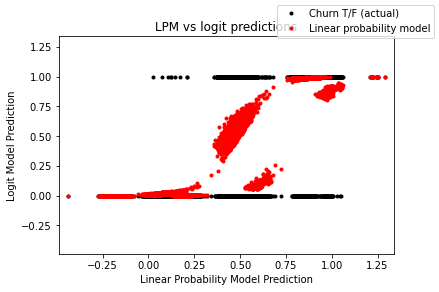

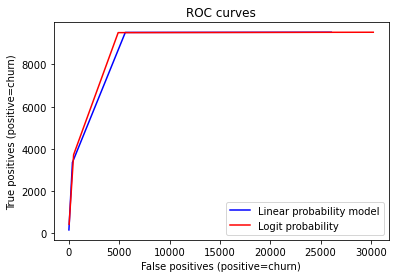

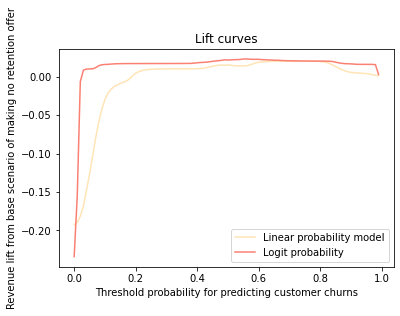

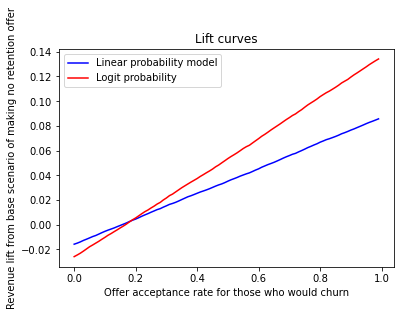

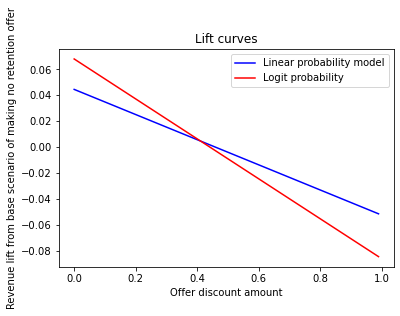

In [79]:
# ----- EVALUATE MODEL PERFORMANCE -----
# --- evaluate model predictions on test set graphically
df_test['prob_churn_lpm'] = lpm_results.predict(df_test[x_col_name])
df_test['prob_churn_logit'] = logit_results.predict(df_test[x_col_name])

# plot predictions vs. data
# select_plot_coef = [x for x in x_col_name if x != 'const']
# n_rows = 20
# n_cols = math.ceil(len(select_plot_coef) / n_rows)
# fig, axes = plt.subplots(n_rows, n_cols)
# fig.suptitle('Single factor relationship with churn')
# for i in range(n_rows):
#     for j in range(n_cols):
#         select_coef = select_plot_coef[i * n_cols + j]
#         axes[i, j].plot(df_test[select_coef], df_test['current_sub_TF'], 'k.')
#         axes[i, j].plot(df_test[select_coef], df_test['prob_churn_lpm'], 'b.')
#         axes[i, j].plot(df_test[select_coef], df_test['prob_churn_logit'], 'r.')
#         axes[i, j].set(xlabel=select_coef, ylabel='Churn prob.')
# fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

# compare lpm and logit predictions
fig = plt.figure()
ax = plt.gca()
ax.plot(df_test[['prob_churn_lpm']], df_test[['churn_TF']], 'k.')
ax.plot(df_test[['prob_churn_lpm']], df_test[['prob_churn_logit']], 'r.')
plt.ylim(df_test[['prob_churn_lpm', 'prob_churn_logit']].min().min()-.05, df_test[['prob_churn_lpm', 'prob_churn_logit']].max().max()+.05)
plt.xlim(ax.get_ylim())
plt.title('LPM vs logit predictions')
plt.xlabel('Linear Probability Model Prediction')
plt.ylabel('Logit Model Prediction')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

# --- evaluate model predictions using numerical quantification (ROC curves)
# make confusion matrices
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_logit'])
lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_lpm'])

# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(lpm_false_positives, lpm_true_positives, 'b-')
ax1.plot(logit_false_positives, logit_true_positives, 'r-')
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 10
discount_amount = 0.3
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])

# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], color='moccasin')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], color='salmon')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Acceptance rate sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['lpm_offer'], 'b-')
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])